# Verification Demos
This notebook contains demonstrations of some features of FDT verification
and visualizations to help understand the concepts.
Feel free to change parameters and see what happens.
You can change the model, but can only visualize it if it maps R^2 -> R^1 or R^2 -> R^2.

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import fdt_verification
from fdt_verification import *
from util import *

# Setup (run before other sections)

### Check installed solvers

In [2]:
cp.installed_solvers()

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'GUROBI', 'OSQP', 'SCS']

### Choose one of the available solvers

In [3]:
fdt_verification.solver = cp.ECOS # choose a solver manually
fdt_verification.solver = None # or set to None to let cvxpy decide

### Load a Fuzzy Decision Tree

In [4]:
f = load_model("moons")

# Specifying a Domain for Verification

In [5]:
n = 200
box = [[-10,10],[-10,10]]
grid = make_grid(box, n)
def show(D): # show a domain
    # check whether grid points are inside the cone
    y = D.contains(grid).reshape((n,n)).astype(int)
    # make sure color behavior is consistent for all-in or all-out cases
    y[0,0] = 0
    y[0,1] = 2
    # show the cone in green
    plt.figure(figsize=(3,3))
    plt.imshow(np.flip(y, axis=0), extent=(box[0][0], box[0][1], box[1][0], box[1][1]), cmap="Greens")
    plt.show()

### Linear constraints (a^T x <= b)

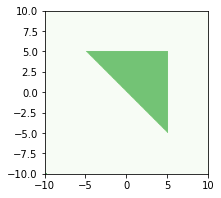

In [6]:
# may enter one or multiple linear constraints at a time
# use this method to add linear constraints to ensure they are handled efficiently
show(VerificationDomain(2).lin(np.array([-1,-1]), 0).lin(np.array([[1,0],[0,1]]), np.array([5,5])))

### Other constraints
see https://www.cvxpy.org/api_reference/cvxpy.constraints.html for more options

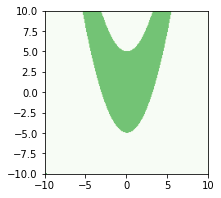

In [7]:
D = VerificationDomain(2)
D.constrain(D.x[0]**2 >= 2*D.x[1] - 10)
# if you alter constraints by other means, set the flag to recompile on next solve call
D.constraints.append(D.x[0]**2 <= 2*D.x[1] + 10)
D.needs_recompile = True
show(D)

### Constraint helper functions

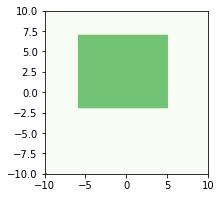

In [8]:
show(VerificationDomain(2).box(np.array([[-6,5],[-2,7]])))

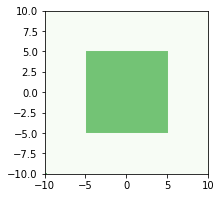

In [9]:
show(VerificationDomain(2).ball_linf(np.array([0,0]), 5))

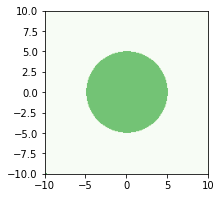

In [10]:
show(VerificationDomain(2).ball_l2(np.array([0,0]), 5))

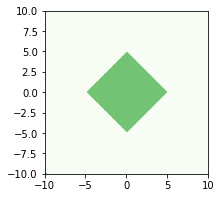

In [11]:
show(VerificationDomain(2).ball_l1(np.array([0,0]), 5))

# Maximization and Verification

### Specify the domain and the function to maximize

In [12]:
D = VerificationDomain(2).box(np.array([[-0.8,-0.4],[0.6,0.9]]))
a = np.array([1,0]) # maximize a^T f(x)
f.set_bounding_coefficients(a)

### Visualize the domain

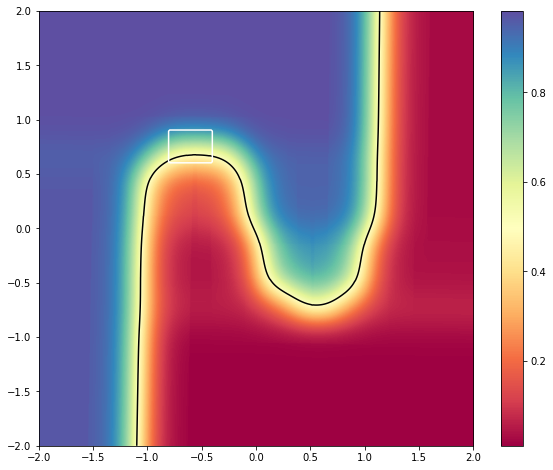

In [13]:
n1, n2 = 1000, 200 # size of the grids for f and D
grid1 = make_grid([[-2,2],[-2,2]], n1)
grid2 = make_grid([[-2,2],[-2,2]], n2)
y = f(grid1)
plt.figure(figsize=(10,8))
# show heatmap of a^T f(x)
plt.imshow(np.flip((y@a).reshape((n1,n1)), axis=0), extent=(-2, 2, -2, 2), cmap="Spectral")
plt.colorbar()
# show decision boundary
plt.contour(grid1[:,0].reshape((n1,n1)), grid1[:,1].reshape((n1,n1)), y[:,0].reshape((n1,n1)), [0.5], colors=["k"])
# show domain
plt.contour(grid2[:,0].reshape((n2,n2)), grid2[:,1].reshape((n2,n2)), D.contains(grid2).reshape((n2,n2)), [0.5], colors=["w"])
plt.show()

### Maximize using our algorithm

In [14]:
l, u, info = verify_fdt(f, D, tol=1e-4)
info["status"], l, u, info["x"], info["iterations"], info["time"]

('success',
 0.8695844301203691,
 0.8696530605553735,
 array([-0.79986581,  0.8999677 ]),
 24,
 0.9060454368591309)

### Show the convergence

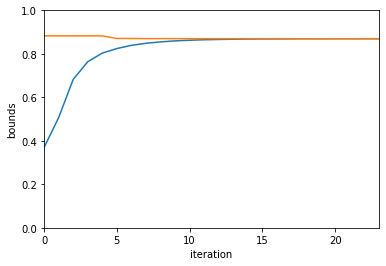

In [15]:
plt.plot(info["lbound"])
plt.plot(info["ubound"])
plt.xlim(0, info["iterations"]-1)
plt.ylim(0, 1)
plt.xlabel("iteration")
plt.ylabel("bounds")
plt.show()

### Verify properties

In [16]:
bs = [0, 0.8, 0.865, 0.87, 0.9] # to verify a^T f(x) <= b
for b in bs:
    property_holds, info = verify_fdt(f, D, b=b)
    print("%4.2f"%b, info["status"], property_holds, info["iterations"], info["time"])

0.00 success False 1 0.02643895149230957
0.80 success False 5 0.20815467834472656
0.86 success False 13 0.45352864265441895
0.87 success True 10 0.3693356513977051
0.90 success True 1 0.025883197784423828


### Additional stopping conditions: maximum iterations

In [17]:
for b in bs:
    property_holds, info = verify_fdt(f, D, b=b, max_it=10)
    print("%4.2f"%b, info["status"], property_holds, info["iterations"], info["time"])

0.00 success False 1 0.025001049041748047
0.80 success False 5 0.19400930404663086
0.86 iteration limit reached None 10 0.36196279525756836
0.87 success True 10 0.3723602294921875
0.90 success True 1 0.025810956954956055


### Additional stopping conditions: timeout

In [18]:
for b in bs:
    property_holds, info = verify_fdt(f, D, b=b, timeout=0.3)
    print("%4.2f"%b, info["status"], property_holds, info["iterations"], info["time"])

0.00 success False 1 0.026315927505493164
0.80 success False 5 0.19490742683410645
0.86 timeout None 8 0.3045215606689453
0.87 timeout None 9 0.3311491012573242
0.90 success True 1 0.02557373046875


# Local Adversarial Robustness

### Specify delta and some points

In [19]:
delta = 0.2
x = np.array([[0.5, 1], 
              [0.2, 0],
              [-1, -1]])

## L-infinity
### Show the delta neighborhoods

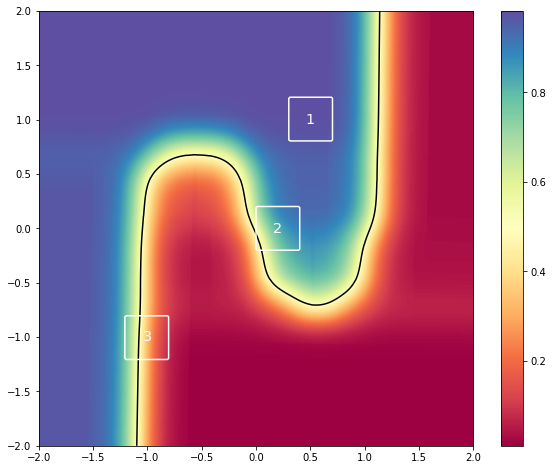

In [20]:
n1, n2 = 1000, 200 # size of the grids for f and D
grid1 = make_grid([[-2,2],[-2,2]], n1)
grid2 = make_grid([[-2,2],[-2,2]], n2)
y = f(grid1)
plt.figure(figsize=(10,8))
# show heatmap of a^T f(x)
plt.imshow(np.flip((y@a).reshape((n1,n1)), axis=0), extent=(-2, 2, -2, 2), cmap="Spectral")
plt.colorbar()
# show decision boundary
plt.contour(grid1[:,0].reshape((n1,n1)), grid1[:,1].reshape((n1,n1)), y[:,0].reshape((n1,n1)), [0.5], colors=["k"])
# show delta neighborhoods
for i, xi in enumerate(x):
    plt.text(xi[0], xi[1], str(i+1), c="white", ha="center", va="center", size="x-large")
    plt.contour(grid2[:,0].reshape((n2,n2)), grid2[:,1].reshape((n2,n2)), VerificationDomain(2).ball_linf(xi, delta).contains(grid2).reshape((n2,n2)), [0.5], colors=["w"])
plt.show()

### Check robustness

In [21]:
robust, success, counterexample, time = check_local_robustness(f, x, delta, norm="inf")
for i, (r, s, ce, t) in enumerate(zip(robust, success, counterexample, time)): print(i+1, r, s, ce, t)

1 True True [0. 0.] 0.026712656021118164
2 False True [ 0.0292933 -0.2      ] 0.2599973678588867
3 False True [-1.11256649 -0.8       ] 0.06913065910339355


### Find and visualize minimum adversarial perturbations

1 0.9 4.2652952671051025
2 0.9 1.8516111373901367
3 0.9 1.3563847541809082


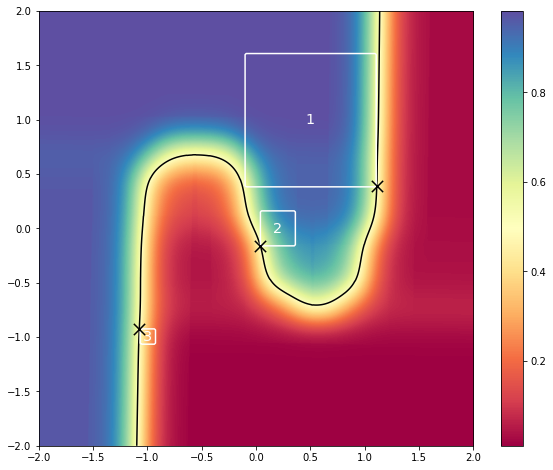

In [22]:
perturbation, dist, exact, times = minimum_adversarial_perturbation(f, x, 1e-3, norm="inf")
for i, (p, d, t) in enumerate(zip(perturbation, dist, times)):
    print(i+1, b, t)
plt.figure(figsize=(10,8))
# show heatmap of a^T f(x)
plt.imshow(np.flip((y@a).reshape((n1,n1)), axis=0), extent=(-2, 2, -2, 2), cmap="Spectral")
plt.colorbar()
# show decision boundary
plt.contour(grid1[:,0].reshape((n1,n1)), grid1[:,1].reshape((n1,n1)), y[:,0].reshape((n1,n1)), [0.5], colors=["k"])
# show delta neighborhoods
for i, xi in enumerate(x):
    plt.text(xi[0], xi[1], str(i+1), c="white", ha="center", va="center", size="x-large")
    plt.contour(grid2[:,0].reshape((n2,n2)), grid2[:,1].reshape((n2,n2)), VerificationDomain(2).ball_linf(xi, dist[i]).contains(grid2).reshape((n2,n2)), [0.5], colors=["w"])
# show the perturbations
plt.scatter(perturbation[:,0], perturbation[:,1], marker="x", c="k", s=128, zorder=2)
plt.show()

## L2
### Show the delta neighborhoods

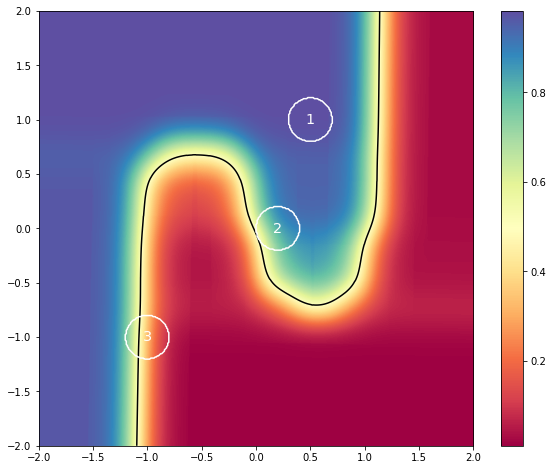

In [23]:
n1, n2 = 1000, 400 # size of the grids for f and D
grid1 = make_grid([[-2,2],[-2,2]], n1)
grid2 = make_grid([[-2,2],[-2,2]], n2)
y = f(grid1)
plt.figure(figsize=(10,8))
# show heatmap of a^T f(x)
plt.imshow(np.flip((y@a).reshape((n1,n1)), axis=0), extent=(-2, 2, -2, 2), cmap="Spectral")
plt.colorbar()
# show decision boundary
plt.contour(grid1[:,0].reshape((n1,n1)), grid1[:,1].reshape((n1,n1)), y[:,0].reshape((n1,n1)), [0.5], colors=["k"])
# show delta neighborhoods
for i, xi in enumerate(x):
    plt.text(xi[0], xi[1], str(i+1), c="white", ha="center", va="center", size="x-large")
    plt.contour(grid2[:,0].reshape((n2,n2)), grid2[:,1].reshape((n2,n2)), VerificationDomain(2).ball_l2(xi, delta).contains(grid2).reshape((n2,n2)), [0.5], colors=["w"])
plt.show()

### Check robustness

In [24]:
robust, success, counterexample, time = check_local_robustness(f, x, delta, norm="l2")
for i, (r, s, ce, t) in enumerate(zip(robust, success, counterexample, time)): print(i+1, r, s, ce, t)

1 True True [0. 0.] 0.0340118408203125
2 True True [0. 0.] 0.7872531414031982
3 False True [-1.11151671 -0.83397583] 0.09404611587524414


### Find and visualize minimum adversarial perturbations

1 0.9 4.2671449184417725
2 0.9 15.4024338722229
3 0.9 2.591082811355591


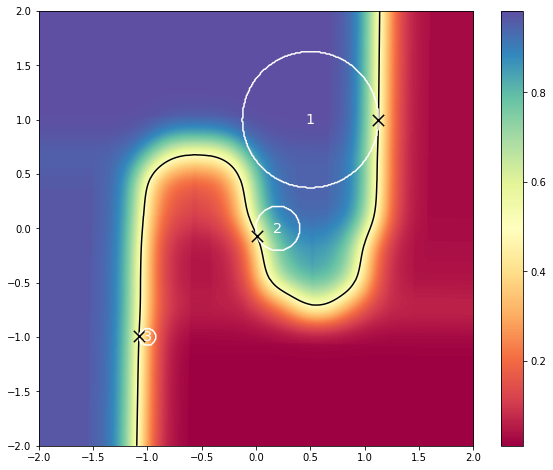

In [25]:
perturbation, dist, exact, times = minimum_adversarial_perturbation(f, x, 1e-3, norm="l2")
for i, (p, d, t) in enumerate(zip(perturbation, dist, times)):
    print(i+1, b, t)
plt.figure(figsize=(10,8))
# show heatmap of a^T f(x)
plt.imshow(np.flip((y@a).reshape((n1,n1)), axis=0), extent=(-2, 2, -2, 2), cmap="Spectral")
plt.colorbar()
# show decision boundary
plt.contour(grid1[:,0].reshape((n1,n1)), grid1[:,1].reshape((n1,n1)), y[:,0].reshape((n1,n1)), [0.5], colors=["k"])
# show delta neighborhoods
for i, xi in enumerate(x):
    plt.text(xi[0], xi[1], str(i+1), c="white", ha="center", va="center", size="x-large")
    plt.contour(grid2[:,0].reshape((n2,n2)), grid2[:,1].reshape((n2,n2)), VerificationDomain(2).ball_l2(xi, dist[i]).contains(grid2).reshape((n2,n2)), [0.5], colors=["w"])
# show the perturbations
plt.scatter(perturbation[:,0], perturbation[:,1], marker="x", c="k", s=128, zorder=2)
plt.show()

## L1
### Show the delta neighborhoods

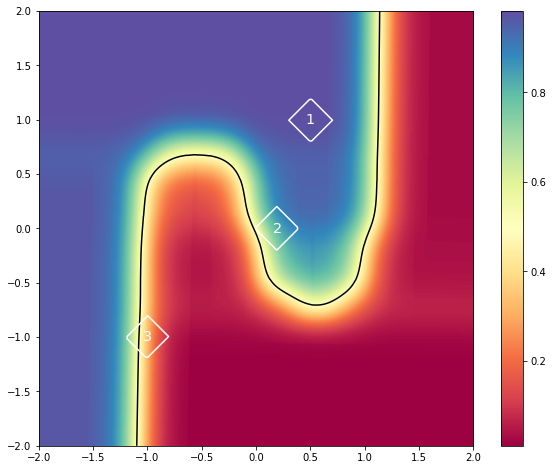

In [26]:
n1, n2 = 1000, 200 # size of the grids for f and D
grid1 = make_grid([[-2,2],[-2,2]], n1)
grid2 = make_grid([[-2,2],[-2,2]], n2)
y = f(grid1)
plt.figure(figsize=(10,8))
# show heatmap of a^T f(x)
plt.imshow(np.flip((y@a).reshape((n1,n1)), axis=0), extent=(-2, 2, -2, 2), cmap="Spectral")
plt.colorbar()
# show decision boundary
plt.contour(grid1[:,0].reshape((n1,n1)), grid1[:,1].reshape((n1,n1)), y[:,0].reshape((n1,n1)), [0.5], colors=["k"])
# show delta neighborhoods
for i, xi in enumerate(x):
    plt.text(xi[0], xi[1], str(i+1), c="white", ha="center", va="center", size="x-large")
    plt.contour(grid2[:,0].reshape((n2,n2)), grid2[:,1].reshape((n2,n2)), VerificationDomain(2).ball_l1(xi, delta).contains(grid2).reshape((n2,n2)), [0.5], colors=["w"])
plt.show()

### Check robustness

In [27]:
robust, success, counterexample, time = check_local_robustness(f, x, delta, norm="l1")
for i, (r, s, ce, t) in enumerate(zip(robust, success, counterexample, time)): print(i+1, r, s, ce, t)

1 True True [0. 0.] 0.027953386306762695
2 True True [0. 0.] 0.16485810279846191
3 False True [-1.11287839 -0.91287839] 0.0740816593170166


### Find and visualize minimum adversarial perturbations

1 0.9 2.791940927505493
2 0.9 3.6523971557617188
3 0.9 1.399740219116211


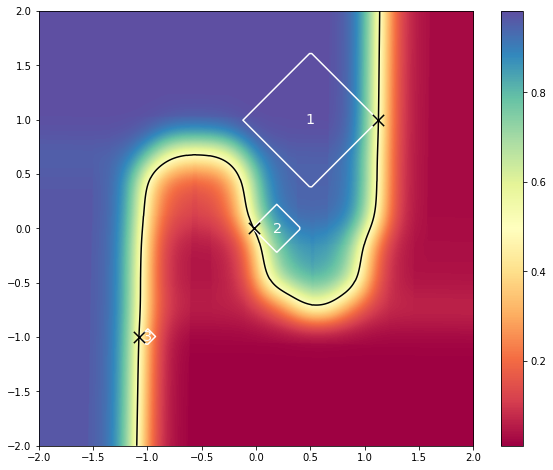

In [28]:
perturbation, dist, exact, times = minimum_adversarial_perturbation(f, x, 1e-3, norm="l1")
for i, (p, d, t) in enumerate(zip(perturbation, dist, times)):
    print(i+1, b, t)
plt.figure(figsize=(10,8))
# show heatmap of a^T f(x)
plt.imshow(np.flip((y@a).reshape((n1,n1)), axis=0), extent=(-2, 2, -2, 2), cmap="Spectral")
plt.colorbar()
# show decision boundary
plt.contour(grid1[:,0].reshape((n1,n1)), grid1[:,1].reshape((n1,n1)), y[:,0].reshape((n1,n1)), [0.5], colors=["k"])
# show delta neighborhoods
for i, xi in enumerate(x):
    plt.text(xi[0], xi[1], str(i+1), c="white", ha="center", va="center", size="x-large")
    plt.contour(grid2[:,0].reshape((n2,n2)), grid2[:,1].reshape((n2,n2)), VerificationDomain(2).ball_l1(xi, dist[i]).contains(grid2).reshape((n2,n2)), [0.5], colors=["w"])
# show the perturbations
plt.scatter(perturbation[:,0], perturbation[:,1], marker="x", c="k", s=128, zorder=2)
plt.show()

# Global Adversarial Robustness

In [29]:
n = 1000
grid = make_grid([[-2,2],[-2,2]], n)
y = f(grid)
def gab(delta, epsilon):
    v, x, t = global_robustness(f, delta, epsilon, bound=2) # limit to [-2,2]^p
    print(v, t)
    if not v:
        plt.figure(figsize=(10,8))
        # show heatmap of a^T f(x)
        plt.imshow(np.flip(y[:,0].reshape((n,n)), axis=0), extent=(-2, 2, -2, 2), cmap="Spectral")
        plt.colorbar()
        # show decision boundary
        plt.contour(grid[:,0].reshape((n,n)), grid[:,1].reshape((n1,n1)), y[:,0].reshape((n,n)), [0.5], colors=["k"])
        # show the pair of points that violates global adversarial robustness
        plt.scatter(x[:,0], x[:,1], marker="x", c="k", s=128, zorder=2)
        plt.show()

### Test for given (delta, epsilon) and show violation if applicable

False 21.931875467300415


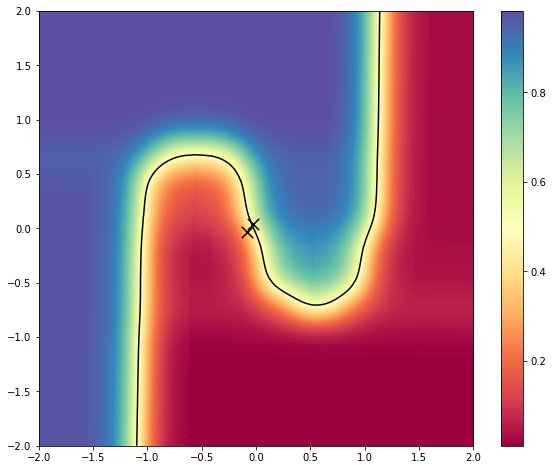

In [30]:
gab(0.1, 0.1)

In [31]:
gab(0.1, 0.5)

True 26.384155750274658


False 10.515785694122314


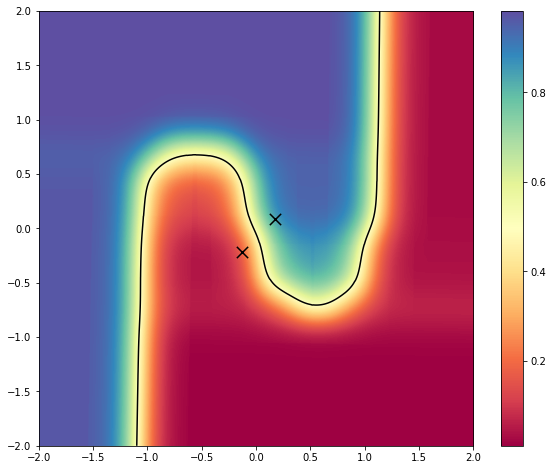

In [32]:
gab(0.3, 0.5)

In [33]:
gab(0.3, 0.9)

True 5.109564542770386


In [34]:
gab(0.5, 0.9)

True 7.301199913024902


False 12.245380163192749


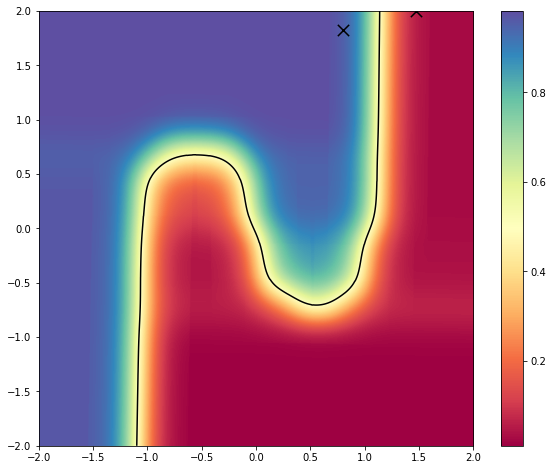

In [35]:
gab(0.7, 0.9)

In [36]:
gab(0.7, 0.95)

True 5.3440492153167725


False 55.69486999511719


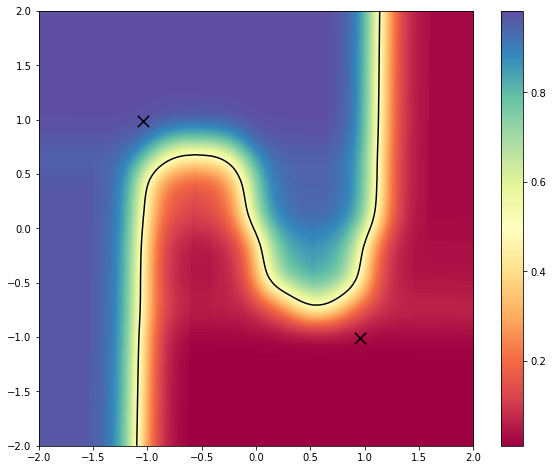

In [37]:
gab(2.0, 0.95)

In [38]:
gab(2.0, 0.97)

True 56.557331800460815


# More complex functions

In [39]:
D = VerificationDomain(2).box(np.array([[-0.8,-0.4],[0.6,0.9]]))
f.set_bounding_coefficients(np.array([1,0]))

def maximize(f):
    l, u, info = verify_fdt(f, D, tol=1e-4)
    print(info["status"], l, u, info["x"], info["iterations"], info["time"])

In [40]:
# f_1(x)
maximize(f)

success 0.8695844301203691 0.8696530605553735 [-0.79986581  0.8999677 ] 24 0.8937773704528809


In [41]:
# 2f_1(x) + 1
maximize(f.mult(2).add(1))

success 2.7392369313499945 2.7393045672477623 [-0.79993297  0.89998445] 26 1.0459468364715576


In [42]:
# f_1(x)^2 + f_2(x)^2
g = f.copy().set_bounding_coefficients(np.array([0,1]))
maximize(f.mult(f).add(g.mult(g))) # multiplying FDTs produces an FDDAG

success 0.7732267950140359 0.7732944309096486 [-0.79993297  0.89998445] 32 14.967958927154541


In [43]:
# -f_1(x)f_2(x)
g = f.copy().set_bounding_coefficients(np.array([0,-1]))
maximize(f.mult(g))

success -0.11341627282429767 -0.113347642391908 [-0.7999613   0.89996453] 27 2.5019023418426514


In [44]:
# exp(x_1 + 2x_2)f_1(x)
maximize(f.mult_sigma(np.array([1,2]), np.exp, np.log))

success 3.4602824878124196 3.4603399168689 [-0.4         0.89999999] 17 0.6617796421051025
